In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob

# Replace this with your own to SBI stream
sys.path.append('/global/u2/t/tvnguyen/sbi_stream')

import pickle

import corner
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import astropy.constants as const
import astropy.units as u
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

import datasets
from sbi.utils import BoxUniform
from sbi_stream import infer_utils
from sbi_stream.npe import NPE

/global/homes/t/tvnguyen/.conda/envs/torch-py11/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def get_val_loss(chkpt_path):
    fname = os.path.basename(chkpt_path)
    try:
        val_loss_str = fname.split('val_loss=')[-1].split('.ckpt')[0]
        return float(val_loss_str)
    except Exception:
        return float('inf')

In [ ]:
run_dir = 'uncertainty'
run_names = [
    'spline-6d-present-large-nodensity',
    'spline-2d-future-large-nodensity',
    'spline-6d-future-large-nodensity',
]
checkpoints = [None, None, None,]

models = []
for run_name, checkpoint in zip(run_names, checkpoints):
    features = ['phi1', 'phi2', 'pm1', 'pm2', 'vr', 'dist']
    labels = ['log_M_sat', 'log_rs_sat', 'vz', 'vphi', 'r', 'phi']

    # find the best checkpoint based on validation loss if None
    if checkpoint is None:
        checkpoint_paths = glob.glob(
            os.path.join(run_dir, run_name, 'lightning_logs/checkpoints/*.ckpt'))
        checkpoint_list = sorted(glob.glob(os.path.join(run_dir, run_name, 'lightning_logs/checkpoints/*.ckpt')))
        best_checkpoint = min(checkpoint_list, key=get_val_loss)
        checkpoint = os.path.basename(best_checkpoint)
    checkpoint_path = os.path.join(
        run_dir, run_name, 'lightning_logs/checkpoints/', checkpoint)

    print(f"Using checkpoint {checkpoint} for run {run_name}")

    # read in the dataset and run on the validation dataset
    device = torch.device('cuda')
    model = NPE.load_from_checkpoint(checkpoint_path, map_location=device).eval()
    models.append(model)

Using checkpoint epoch=91-step=48576-train_loss=-1.1512-val_loss=-0.9339.ckpt for run uncertainty-nsf10/spline-6d-present-large-nodensity
Using checkpoint epoch=127-step=67584-train_loss=-5.8271-val_loss=-5.3056.ckpt for run uncertainty-nsf10/spline-2d-future-large-nodensity
Using checkpoint epoch=100-step=53328-train_loss=-2.9166-val_loss=-2.4755.ckpt for run uncertainty-nsf10/spline-6d-future-large-nodensity


In [ ]:
# This is a shared directory, you can use it as is or copy the datasets to your own location
data_root = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/preprocessed_datasets/AAU'
data_names = [
   '6d-AAU-spline-present',
   '2d-AAU-spline-future',
   '6d-AAU-spline-future',
]

In [16]:
def load_data(data_root, data_name, norm_dict, device):

    x, y, t, padding_mask = datasets.read_processed_datasets(
        os.path.join(data_root, data_name),
        num_datasets=1,
        start_dataset=0,
    )
    x = x[:1]
    y = y[:1]
    t = t[:1]
    padding_mask = padding_mask[:1]
    x_loc = norm_dict["x_loc"]
    x_scale = norm_dict["x_scale"]
    y_loc = norm_dict["y_loc"]
    y_scale = norm_dict["y_scale"]
    t_loc = norm_dict["t_loc"]
    t_scale = norm_dict["t_scale"]
    x_norm = (x - x_loc) / x_scale
    y_norm = (y - y_loc) / y_scale
    t_norm = (t - t_loc) / t_scale

    # convert to tensors
    x_norm = torch.tensor(x_norm, dtype=torch.float32, device=device)
    y_norm = torch.tensor(y_norm, dtype=torch.float32, device=device)
    t_norm = torch.tensor(t_norm, dtype=torch.float32, device=device)
    padding_mask = torch.tensor(padding_mask, dtype=torch.bool, device=device)

    return (x_norm, y_norm, t_norm, padding_mask)

In [17]:
pl.seed_everything(31)

prior_min = [-4, -1, -100, -100, 0, 0, ]
prior_max = [-2, 0, 100, 100, 3, 360]
prior_min = torch.tensor(prior_min, dtype=torch.float32)
prior_max = torch.tensor(prior_max, dtype=torch.float32)
prior = BoxUniform(low=prior_min, high=prior_max, device=device)

num_samples = 100_000

all_samples = []
all_truths = []

with torch.no_grad():
    for model, data_name in zip(models, data_names):
        norm_dict = model.norm_dict

        print(f"Loading data for {data_name}")
        x_norm, y_norm, t_norm, padding_mask = load_data(
            data_root, data_name, norm_dict, device=device)

        # sample
        flow_context = model(x_norm, t_norm, padding_mask)
        flow = model.flows(flow_context)
        sample = flow.sample((num_samples,))
        log_prob = flow.log_prob(sample)
        log_prob = torch.transpose(log_prob, 0, 1)
        sample = torch.transpose(sample, 0, 1)

        # denormalize
        y_scale = torch.tensor(norm_dict["y_scale"], dtype=torch.float32, device=device)
        y_loc = torch.tensor(norm_dict["y_loc"], dtype=torch.float32, device=device)
        sample = sample * y_scale + y_loc
        y = y_norm * y_scale + y_loc

        prior_logprob = prior.log_prob(sample)
        mask = ~torch.isinf(prior_logprob)
        prior_logprob = prior_logprob[mask]
        sample = sample[mask]
        log_prob = log_prob[mask]

        sample = sample.cpu().numpy()
        y = y.cpu().numpy()
        log_prob = log_prob.cpu().numpy()

        all_samples.append(sample)
        all_truths.append(y)

Seed set to 31


Loading data for 6d-AAU-spline-present


100%|██████████| 1/1 [00:00<00:00, 494.96it/s]


Loading data for 2d-AAU-spline-future


100%|██████████| 1/1 [00:00<00:00, 530.45it/s]


Loading data for 6d-AAU-spline-future


100%|██████████| 1/1 [00:00<00:00, 466.86it/s]


In [18]:
x_norm1, y_norm1, t_norm1, padding_mask = load_data(
    data_root, data_names[1], models[1].norm_dict, device=device)
x_norm2, y_norm2, t_norm2, padding_mask = load_data(
    data_root, data_names[2], models[2].norm_dict, device=device)

flow1 = models[1].flows(models[1](x_norm1, t_norm1, padding_mask))
flow2 = models[2].flows(models[2](x_norm2, t_norm2, padding_mask))

sample_eval = all_samples[1]
sample_eval_norm = (sample_eval - models[2].norm_dict["y_loc"]) / models[2].norm_dict["y_scale"]
sample_eval_norm = torch.tensor(sample_eval_norm, dtype=torch.float32, device=device)
log_prob2 = flow2.log_prob(sample_eval_norm)
log_weight = log_prob2 - torch.logsumexp(log_prob2, dim=0, keepdim=True)

# resample
resample_idx = torch.multinomial(torch.exp(log_weight), num_samples, replacement=True)
sample = sample_eval[resample_idx.cpu().numpy()]

all_samples.append(sample)
all_truths.append(y_norm2.cpu().numpy())

100%|██████████| 1/1 [00:00<00:00, 412.66it/s]


In [19]:
# do some conversion
all_samples2 = []
all_truths2 = []

for samples, truths in zip(all_samples, all_truths):
    samples2 = np.zeros((samples.shape[0], 6))
    samples2[:, 0] = 10**(samples[:, 0] + 3)  # M_sat
    samples2[:, 1] = 10**samples[:, 1]  # r_sat
    samples2[:, 2] = np.sqrt(samples[:, 2]**2 + samples[:, 3]**2)
    samples2[:, 3] = samples[:, 3]  # vz
    samples2[:, 4] = samples[:, 4]
    samples2[:, 5] = samples[:, 5]
    all_samples2.append(samples2)

    truths2 = np.zeros((truths.shape[0], 6))
    truths2[..., 0] = 10**(truths[..., 0] + 3)
    truths2[..., 1] = 10**truths[..., 1]
    truths2[..., 2] = np.sqrt(truths[..., 2]**2 + truths[..., 3]**2)
    truths2[..., 3] = truths[..., 3]  # vz
    truths2[..., 4] = truths[..., 4]
    truths2[..., 5] = truths[..., 5]
    all_truths2.append(truths2)

In [20]:
def rgb_to_hex(rgb):
    """Convert RGB tuple (0-1 values) to hex color string."""
    r, g, b = rgb
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

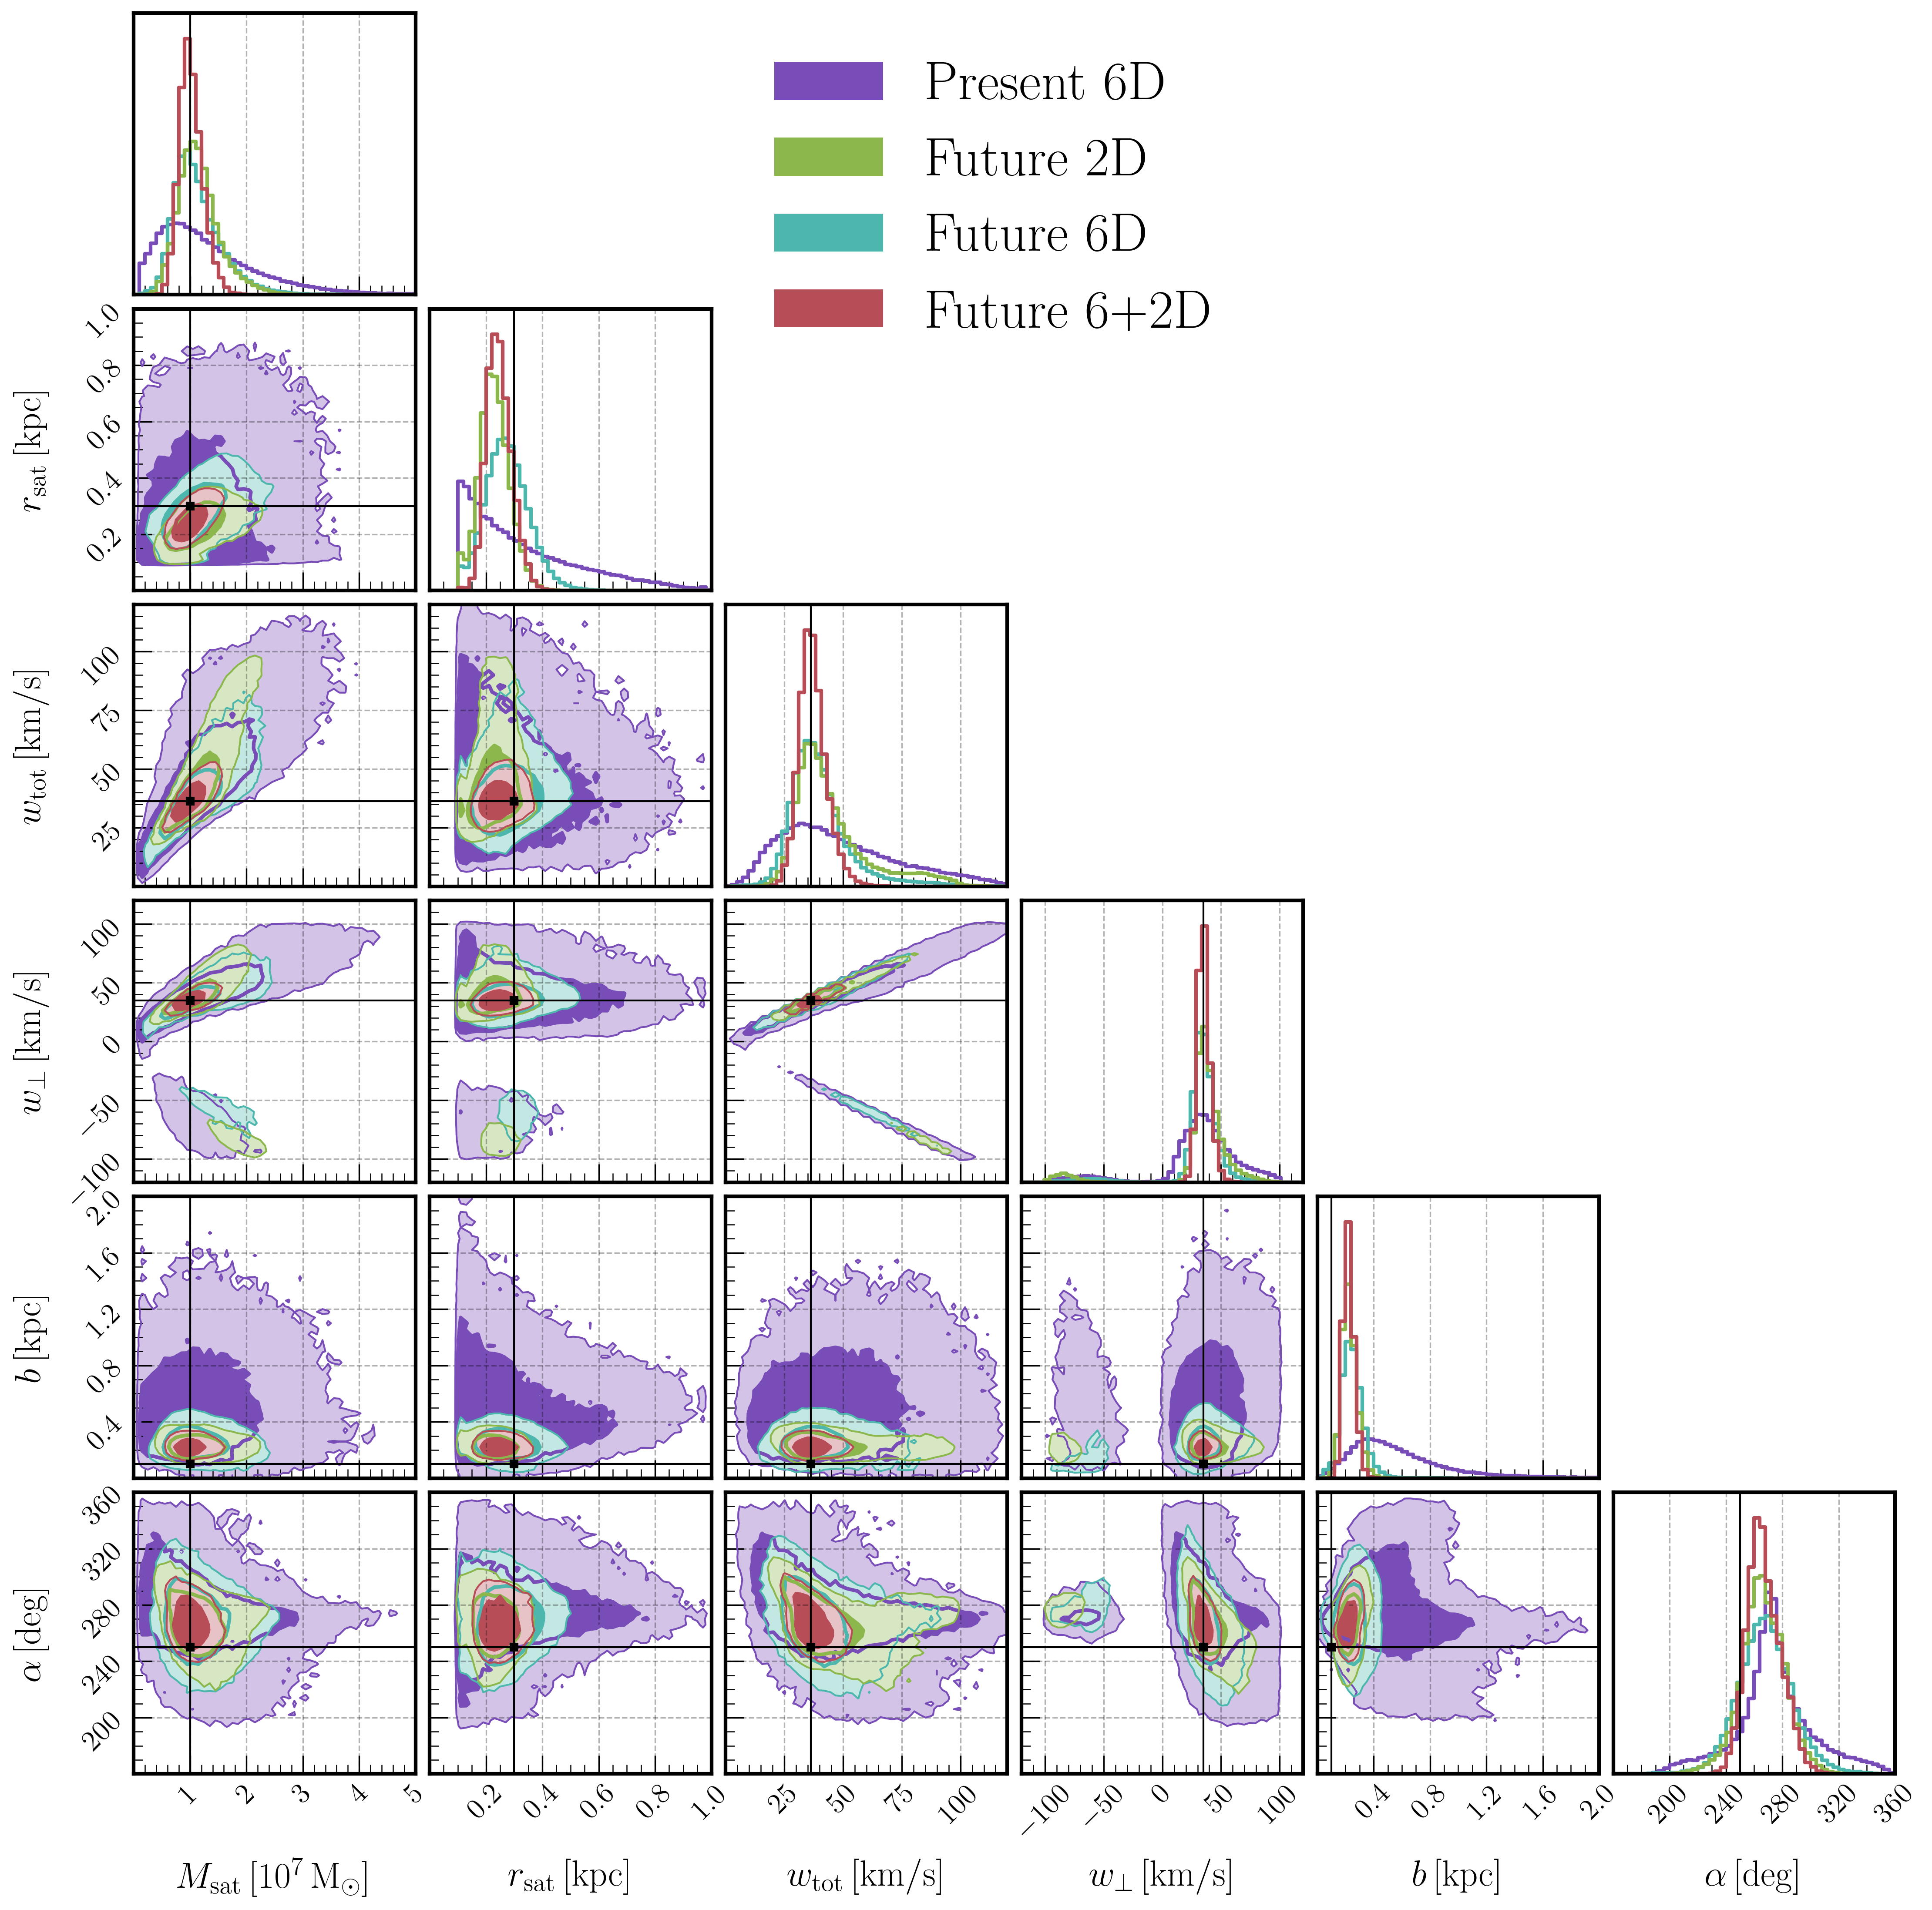

In [21]:
orders = [0, 2, 1, 3]
indices = [0, 1, 2, 3, 4, 5]  # Msat, vtotal, vperp, alpha
n_params = len(indices)

# Corner plot with Msat, vtotal, and vperp
fig, axes = plt.subplots(n_params, n_params, figsize=(15, 15), dpi=300)

# colors = [
#     "C0",
#     "orangered",
#     "#840020",
#     "C6"
# ]

colors = [
    "#784db7",
    "#8cb74d",
    "#4db7ad",
    "#b74d57"
]
# colors = [rgb_to_hex(colors[i]) for i in range(len(colors))]
labels = [
    r'$M_\mathrm{sat} \, [10^7 \,\mathrm{M}_\odot]$',
    r'$r_\mathrm{sat} \, [\mathrm{kpc}]$',
    r'$w_\mathrm{tot} \, [\mathrm{km/s}]$',
    r'$w_\mathrm{\perp} \, [\mathrm{km/s}]$',
    r'$b \, [\mathrm{kpc}]$',
    r'$\alpha \, [\mathrm{deg}]$',
]
plot_range = [
    [0., 5],
    [0.0, 1],
    [0, 120],
    [-120, 120],
    [0, 2.0],
    [160, 360],
]
smooth = 0
smooth1d = 0
bins = 50


# plot 2D first since it's the widest
for i in orders:
    array = all_samples2[i][:, indices]
    fig = corner.corner(
        array,
        color=colors[i],
        contour_kwargs=dict(linestyles=["solid", "solid"], linewidths=[1, 2]),
        levels=(0.68, 0.95, ),
        show_titles=False,
        label_kwargs=dict(fontsize=20),
        labels=labels,
        plot_contours=True,
        plot_datapoints=False,
        plot_density=False,
        fill_contours=True,
        bins=bins,
        hist_bin_factor=1,
        smooth=smooth,
        smooth1d=smooth1d,
        range=plot_range,
        fig=fig,
        hist_kwargs=dict(
            linewidth=2,
            alpha=1,
        ),
    )

# plot the truth values manually
truth = all_truths2[0][0, indices]
truth_color = 'k'

# Add vertical lines on diagonal plots (histograms)
for i in range(n_params):
    ax = axes.ravel()[i * (n_params + 1)]  # Diagonal elements
    ax.axvline(truth[i], color=truth_color, linestyle='-', linewidth=1)

# Add lines on off-diagonal plots
for i in range(n_params):
    for j in range(i):
        ax = axes.ravel()[i * n_params + j]
        ax.axvline(truth[j], color=truth_color, linestyle='-', linewidth=1, alpha=1)
        ax.axhline(truth[i], color=truth_color, linestyle='-', linewidth=1, alpha=1)
        ax.plot(truth[j], truth[i], truth_color + 's', markersize=4, alpha=1)

# # set axis limit
# for i in range(n_params):
#     for j in range(n_params):
#         ax = axes[i, j]
#         if i == j:  # Diagonal elements
#             ax.set_xlim(plot_range[i])
#         else:
#             ax.set_xlim(plot_range[j])
#             ax.set_ylim(plot_range[i])

# axes[0, 0].set_ylim(None, 15_000)
# axes[1, 1].set_ylim(None, 15_000)
# axes[2, 2].set_ylim(None, 15_000)
# axes[3, 3].set_ylim(None, 25_000)
# axes[4, 4].set_ylim(None, 12_000)
# axes[5, 5].set_ylim(None, 12_000)

legend_elements = []
labels = [
   'Present 6D',
   'Future 2D',
   'Future 6D',
   'Future 6+2D'
]
for i in range(len(orders)):
    legend_elements.append(Patch(facecolor=colors[i], label=labels[i]))

# Add legend to the figure
axes.ravel()[2].legend(
    handles=legend_elements, loc='upper left',
    # bbox_to_anchor=(0.7, 0.98),
    fontsize=30,
    frameon=False,
)
# fig.tight_layout()
fig.savefig('figures/corner6d_err_mv.pdf', bbox_inches='tight', dpi=300)

In [22]:
for i in range(len(all_samples)):
    samples = all_samples2[i]

    for j in range(samples.shape[1]):
        # hdi = arviz.hdi(samples[..., j], hdi_prob=0.68, multimodal=False)
        median = np.median(samples[..., j])        # print(hdi, map_value)
        hdi = np.quantile(samples[..., j], [0.16, 0.84])
        print('{:.2f} +{:.2f} - {:.2f}'.format(median, hdi[1] - median, median - hdi[0]))

    print('---')

1.13 +1.05 - 0.61
0.28 +0.27 - 0.13
43.91 +32.00 - 19.83
35.42 +23.75 - 19.81
0.50 +0.39 - 0.23
272.61 +25.43 - 21.55
---
1.12 +0.39 - 0.30
0.23 +0.06 - 0.05
40.75 +18.29 - 8.58
36.97 +12.31 - 8.01
0.22 +0.06 - 0.05
266.03 +15.30 - 14.16
---
1.06 +0.49 - 0.31
0.27 +0.08 - 0.07
37.89 +12.11 - 8.59
34.64 +9.88 - 8.32
0.24 +0.08 - 0.07
267.37 +18.47 - 18.61
---
1.00 +0.23 - 0.18
0.24 +0.05 - 0.04
36.69 +6.17 - 4.91
34.94 +5.51 - 4.41
0.22 +0.04 - 0.03
265.84 +13.64 - 10.31
---


In [23]:
for i in range(len(all_samples)):
    samples = all_samples[i]

    median = np.median(samples[..., 2])        # print(hdi, map_value)
    hdi = np.quantile(samples[..., 2], [0.16, 0.84])

    print('{:.2f} +{:.2f} - {:.2f}'.format(median, hdi[1] - median, median - hdi[0]))

    print('---')

-14.05 +9.40 - 21.01
---
-12.43 +4.96 - 7.38
---
-11.25 +4.51 - 6.33
---
-10.97 +2.85 - 3.59
---


In [24]:
1.00 +0.23 - 0.18
0.24 +0.05 - 0.04
-10.97 +2.85 - 3.59
34.94 +5.51 - 4.41
36.69 +6.17 - 4.90
0.22 +0.04 - 0.03
265.83 +13.65 - 10.31


269.16999999999996